In [1]:
import sys
sys.path.append('..')

In [2]:
# Deep Learning
import torch
from torch import nn

# Data Utils
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd

# Hand rolled utils
from util import data, metrics, preprocess
from models import spot, networks

# stats
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.seasonal import STL
import scipy.stats as stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# io
import joblib
import os
from pathlib import Path
import datetime

# notebook params
sns.set()
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.titlesize'] = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
np.random.seed(1234)
torch.manual_seed(1234);

## Load Data

,b1,b2,b3,b4
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118


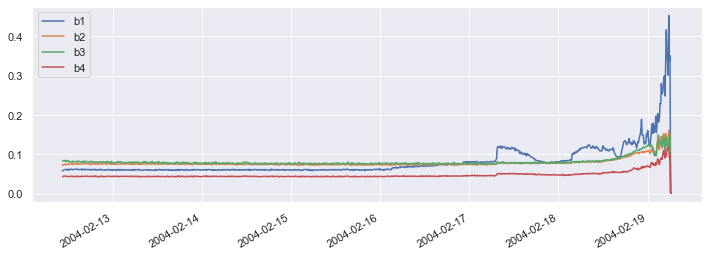

In [3]:
data_dir = Path('data/2nd_test/')
files = [f for f in data_dir.iterdir() if f.is_file()]
vibs_df = pd.DataFrame()

for f in files:
    ten_min_mean = pd.read_csv(f, sep='\t', header=None).abs().mean(axis=0)
    vibs_df = vibs_df.append(ten_min_mean, ignore_index=True)

# create date-time index and columns:
vibs_df.index = [f.name for f in files]
vibs_df.index = pd.to_datetime(vibs_df.index, format='%Y.%m.%d.%H.%M.%S')
vibs_df.columns = ['b1', 'b2', 'b3', 'b4']
vibs_df.sort_index(inplace=True)

vibs_df.plot()
vibs_df.head()

## Preprocess to Dataset/DataLoaders

In [4]:
window = 7
n_features = 4
factor = 2
emb_size = int(window * n_features * factor)

In [5]:
seqs = preprocess.sequence(vibs_df, window)

transform = preprocess.Difference()
train_data = data.SimpleDataset(seqs, transform=transform)
train_loader = DataLoader(train_data, shuffle=True)

## Initialize and Train New Model

In [6]:
model = networks.LSTMEncoderDecoder(n_features, emb_size)

In [7]:
criterion = nn.MSELoss(reduction='sum')
lr = 1e-3
loss = networks.train_encoder(model, 
                             epochs=1000, 
                             lr=lr, 
                             criterion=criterion,
                             trainload=train_loader,
                             testload=train_loader)

Training model on cpu


  0%|          | 0/1000 [00:00<?, ?it/s]

No improvement in 20 epochs. Interrupting training.
Best loss: 0.0003442901140650585
Loading best model weights.
Training complete.


## Visualize Loss

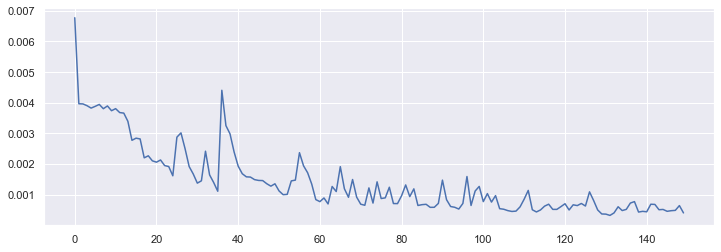

In [8]:
sns.lineplot(data=loss[0]);

In [9]:
torch.save(model.state_dict(), f'models/lstm_md_model_size={emb_size}_lr={lr}.pt')

# Visualize Reconstruction

In [10]:
# Get a random sample:
sample = seqs[30]

# apply difference transform
sample = transform(sample)
sample.shape

torch.Size([7, 4])

In [11]:
# add dimensions for batch size and # features
sample = sample.unsqueeze(0).float()
out = model(sample)

In [12]:
# invert difference transform
sample = transform.inverse(sample.squeeze())
out = transform.inverse(out.squeeze())

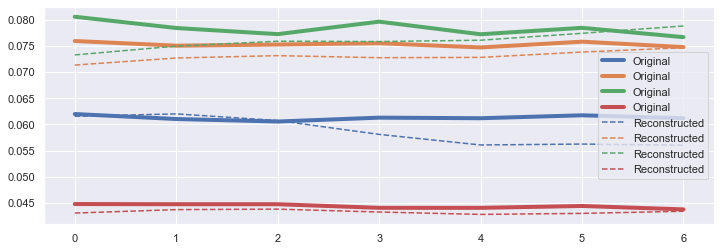

In [13]:
# plot original and reconstruction
plt.plot(sample.detach().numpy().squeeze(), linestyle='-', linewidth=4, label='Original')
plt.gca().set_prop_cycle(None)
plt.plot(out.detach().numpy().squeeze(), linestyle='--', label='Reconstructed')
plt.legend()

## Run Inference on Data

In [14]:
# Run inference on all data.
reconstructed = torch.tensor([])
for seq in train_data:
    x = seq.unsqueeze(0).float()
    with torch.no_grad():
        x_hat = model(x)
        reconstructed = torch.cat((reconstructed, x_hat))

In [15]:
# Invert difference transform
reconstructed = torch.stack([transform.inverse(seq) for seq in reconstructed])

# Concatenate sub-sequences
reconstructed = reconstructed.view(-1, n_features)

## Compute Anomaly Scores

In [16]:
# Get L1 Loss of whole data set.
original = torch.cat(tuple(seqs))
criterion = nn.L1Loss(reduction='none')
loss = criterion(reconstructed, original)

md = metrics.MahalaDistance()
md.fit(loss.numpy())
scores = md.measure(loss.numpy())

loss.shape, scores.shape

(torch.Size([980, 4]), (980,))

## Visualize Anomaly Scores

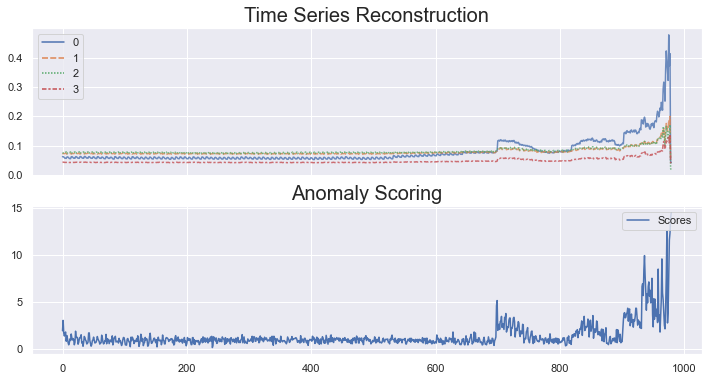

In [17]:
fig, ax, = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

# Reconstruction
sns.lineplot(data=reconstructed.numpy(), linestyle='--', alpha=0.8, ax=ax[0])
ax[0].set_title('Time Series Reconstruction')

# Anomaly Scores
sns.lineplot(data=scores, label='Scores', ax=ax[1])
ax[1].set_title('Anomaly Scoring')

plt.legend(loc='upper right')
plt.show()

## Apply SPOT to Anomaly Scores:

Initial threshold : 1.5663859005373804
Number of peaks : 11
Grimshaw maximum log-likelihood estimation ... bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 122.85840408149419
bounds1 2313.002484055987
step 199.1040072704085
[done]
	γ = -2.9019702196819708e-09
	σ = 0.2901970219681971
	L = 2.6091473842613784
Extreme quantile (probability = 0.0001): 3.0786913702792837


  0%|          | 0/980 [00:00<?, ?it/s]

bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 123.04265029566893
bounds1 2380.1004590601274
step 205.1870735240417
bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 124.61717988640252
bounds1 3149.9742208831253
step 275.0324582724293
bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 124.36934395301721
bounds1 2998.916017376478
step 261.32242485667825
bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 124.1031134700508
bounds1 2851.417752191183
step 247.93769442919384
bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 123.99887068579277
bounds1 2797.384805033359
step 243.03508494068785
bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 123.68262558240535
bounds1 2644.8228704798244
step 229.1945677179472
bounds0 -0.6724257507427144
bounds1 -1e-08
step 0.06112961279479221
bounds0 123.69139238714848
bounds1 2648.837496238113
step 229.5

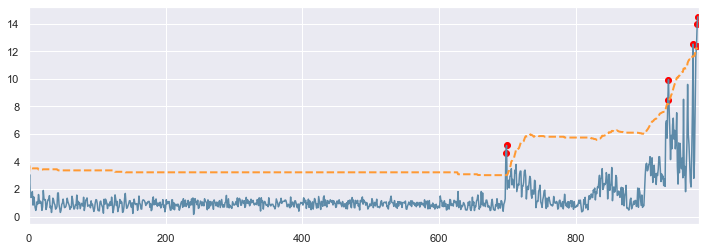

In [18]:
from models import spot

# Split data for initialization step
init_data = scores[:600]

# Risk threshold (probability)
q = 1e-4

# Initialize
sp = spot.SPOT(q)
sp.fit(init_data, scores)
sp.initialize(level=0.98)

# Run
results = sp.run()

# Plot
fig = sp.plot(results);